In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torch
from torch import nn, optim
import numpy as np
import cv2
from utils import timing_decorator, get_images_dir_path
import pandas
from autoencoder import Autoencoder

In [2]:
result_folder = 'autoencoder_results'
output_file_name = 'encoded_vectors.csv'
generated_images_folder = 'generated_images'
encoded_vectors = os.path.join(result_folder, output_file_name)
results_rnn_file = os.path.join(result_folder, 'training_rnn_results.csv')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

### Загрузка векторов

In [3]:
df = pandas.read_csv(encoded_vectors, dtype={'file_name':str, 'encode_vector':str})
df.head()

,file_name,encode_vector
0,image_27358.jpg,"8.11378,1.1557901,-2.1424499,-9.442376,6.71844..."
1,image_07088.jpg,"-2.5879674,-4.5867686,3.0055764,0.22425225,-9...."
2,image_30624.jpg,"4.237051,6.8330345,-5.237319,13.798186,1.47321..."
3,image_11832.jpg,"-7.6320715,0.54696316,-8.56017,-0.63509077,3.8..."
4,image_20437.jpg,"2.425571,12.118851,-22.992817,-6.7715807,-4.24..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47933 entries, 0 to 47932
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      47933 non-null  object
 1   encode_vector  47933 non-null  object
dtypes: object(2)
memory usage: 749.1+ KB


In [5]:
def makeArray(text):
    return np.fromstring(text,sep=',')

In [6]:
df['encode_vector'] = df['encode_vector'].apply(makeArray)

In [7]:
df = df.sort_values(by=['file_name'])

In [8]:
df.head(12)

,file_name,encode_vector
24157,image_00000.jpg,"[-2.2850296, 2.439629, 1.491935, -9.362732, 6...."
26829,image_00001.jpg,"[-1.3955263, 3.1770823, -3.3733964, -5.185953,..."
29740,image_00002.jpg,"[-3.070328, 5.6636457, -13.13622, -9.0368395, ..."
27275,image_00003.jpg,"[7.6021585, 9.363819, -23.031458, -10.117748, ..."
35641,image_00004.jpg,"[10.171621, -0.79664415, -18.933537, -2.322086..."
33195,image_00005.jpg,"[6.8616524, 13.113563, -12.714206, -3.946662, ..."
30284,image_00006.jpg,"[0.088547744, 2.4296923, -3.4688454, -0.509654..."
32526,image_00007.jpg,"[-5.4084187, -4.034243, 2.4636571, -4.7346554,..."
14710,image_00008.jpg,"[-9.834157, -17.30501, -9.228772, -6.593273, -..."
12367,image_00009.jpg,"[-13.847381, -14.681672, -6.7845025, -8.794621..."


### Подготовка данных

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
# X[i] - [from i to i + timesteps]
# y[i] - i + timesteps element (target value )

In [11]:
def create_dataset(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

In [54]:
data = np.stack(df['encode_vector'].values)
timesteps = 10
X, y = create_dataset(data, timesteps)

In [57]:
dataset = TimeSeriesDataset(X, y)
dataloader = DataLoader(dataset, batch_size=47923, shuffle=False)

In [58]:
features, outputs = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Feature [0] batch shape: {features[0].shape}")
print(f"Outputs [0] batch shape: {outputs[0].shape}")

# print(features[0])
# print(outputs[0])

Feature batch shape: torch.Size([47923, 10, 128])
Feature [0] batch shape: torch.Size([10, 128])
Outputs [0] batch shape: torch.Size([128])


### RNN

In [59]:
input_dim = 128
timesteps = 10   # длина временного ряда, используемого для предсказания
num_units = 128  # количество блоков LSTM в первом слое
epochs = 100     
learning_rate = 0.001
num_layers = 3
output_size = 128
hidden_size = 128 * 2

In [60]:
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_dim, num_units, num_layers):
        super(SimpleLSTMModel, self).__init__()
        # self.lstm = nn.LSTM(input_dim, num_units, num_layers, batch_first=True, bidirectional=False)
        # self.fc = nn.Linear(num_units, input_dim)

        self.lstm = nn.LSTM(input_dim, num_units, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(num_units)
        self.fc = nn.Linear(num_units, input_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        # x = self.fc(x[:, -1, :])

        x = self.layer_norm(x[:, -1, :])
        x = self.fc(x)
        return x



In [61]:
class Attention(nn.Module):
    def __init__(self, num_units):
        super(Attention, self).__init__()
        self.attention = nn.Linear(num_units, 1, bias=False)

    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector


class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_dim, num_units, num_layers):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, num_units, num_layers, batch_first=True)
        self.attention = Attention(num_units)
        self.layer_norm = nn.LayerNorm(num_units)
        self.fc = nn.Linear(num_units, input_dim)
        self.residual = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context_vector = self.attention(lstm_out)
        norm_out = self.layer_norm(context_vector)
        output = self.fc(norm_out)
        return output + self.residual(x[:, -1, :]) 

In [62]:
@timing_decorator
def train(num_epochs, dataloader, input_dim, num_units, num_layers):
    # model = SimpleLSTMModel(input_dim, num_units, num_layers)
    model = ImprovedLSTMModel(input_dim, num_units, num_layers)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    model.to(device)

    with open(results_rnn_file, 'w') as f:
        f.write('Epoch,Loss\n')

    print(f'Обучение начато на {num_epochs} эпох')
    for epoch in range(num_epochs):
        train_loss = 0
        for inputs, targets in dataloader:            
            optimizer.zero_grad()

            inputs = inputs.to(device)
            
            outputs = model(inputs)

            loss = loss_function(outputs.cpu(), targets)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            train_loss += loss.item()
            optimizer.step()

        if epoch % 5 == 0:
            print(f'-> Эпоха: {epoch} Средний loss: {train_loss:.4f}')
            with open(results_rnn_file, 'a') as f:
                f.write(f'{epoch+1},{train_loss:.4f}\n')

        
        train_loss /= len(dataloader)
        scheduler.step(train_loss)
    
    torch.save(model.state_dict(), os.path.join(result_folder, f'rnn_model.pth'))
    print('Окончание обучения')

In [63]:
train(150, dataloader, input_dim, num_units, num_layers)

Обучение начато на 150 эпох
-> Эпоха: 0 Средний loss: 88.7387
-> Эпоха: 5 Средний loss: 74.2161
-> Эпоха: 10 Средний loss: 65.1022
-> Эпоха: 15 Средний loss: 58.3757
-> Эпоха: 20 Средний loss: 53.0212
-> Эпоха: 25 Средний loss: 48.5835
-> Эпоха: 30 Средний loss: 44.8102
-> Эпоха: 35 Средний loss: 41.5577
-> Эпоха: 40 Средний loss: 38.7382
-> Эпоха: 45 Средний loss: 36.3139
-> Эпоха: 50 Средний loss: 34.2740
-> Эпоха: 55 Средний loss: 32.5308
-> Эпоха: 60 Средний loss: 31.0200
-> Эпоха: 65 Средний loss: 29.7286
-> Эпоха: 70 Средний loss: 28.6052
-> Эпоха: 75 Средний loss: 27.6344
-> Эпоха: 80 Средний loss: 26.7965
-> Эпоха: 85 Средний loss: 26.1063
-> Эпоха: 90 Средний loss: 25.4912
-> Эпоха: 95 Средний loss: 24.9499
-> Эпоха: 100 Средний loss: 24.4646
-> Эпоха: 105 Средний loss: 24.0343
-> Эпоха: 110 Средний loss: 23.6385
-> Эпоха: 115 Средний loss: 23.2635
-> Эпоха: 120 Средний loss: 22.9505
-> Эпоха: 125 Средний loss: 22.6347
-> Эпоха: 130 Средний loss: 22.3597
-> Эпоха: 135 Средний 

#### Результаты LSTM

In [69]:
def load_lstm_model(model_path, input_dim, num_units, num_layers):
    model = ImprovedLSTMModel(input_dim, num_units, num_layers)
        
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    model.to(device)

    return model


In [70]:
def load_autoencoder_model(model_path):
    model = Autoencoder()
        
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    model.to(device)

    return model


In [71]:
rnn_model_path = os.path.join(result_folder, 'rnn_model.pth')
autoencoder_model_path = os.path.join(result_folder, 'autoencoder.pth')

rnn_model = load_lstm_model(rnn_model_path, input_dim, num_units, num_layers)
autoencoder_model = load_autoencoder_model(autoencoder_model_path)

In [72]:
@timing_decorator
def generate_vectors(model, initial_input, num_predictions):
    model.to(device)
    generated = []
    input_seq = initial_input
    with torch.no_grad():
        for _ in range(num_predictions):
            input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            input_seq_tensor = input_seq_tensor.to(device)

            next_vector = model(input_seq_tensor)
            next_vector = next_vector.squeeze(0).cpu().numpy()

            # save vector 
            generated.append(next_vector)
            # generate add to input new vector
            # input_seq = input_seq[:10]
            input_seq.append(next_vector)

    return generated

In [73]:
@timing_decorator
def generate(test_input_vector, images_count=10):
    new_vectors = generate_vectors(rnn_model, test_input_vector, images_count)
    os.makedirs(generated_images_folder, exist_ok=True)
    images = []
    for i in range(len(new_vectors)):
        vector = new_vectors[i]
        tensor = torch.from_numpy(np.array([vector]))
        tensor = tensor.to(device)
        
        outputs = autoencoder_model.decoder(tensor)
        outputs = outputs[0].cpu().detach().squeeze(0)
        images.append(outputs.numpy())
        
        file_path = os.path.join(generated_images_folder, f'generated_image_{i+1}.jpg')
        
        plt.imshow(outputs, cmap="gray")
        plt.axis('off')
        plt.savefig(file_path)
    return images

Создание изображений


/var/folders/j5/fl61_2bn0kn0kbl76dhw03j80000gn/T/ipykernel_45157/582491005.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)


Время выполнения generate_vectors: 8.79 секунд
Время выполнения generate: 156.93 секунд
Готово


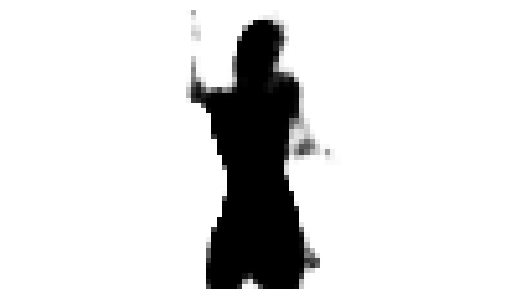

In [74]:
test_input_vector = [df.iloc[100]['encode_vector']]
images_count=250

print("Создание изображений")
images = generate(test_input_vector, images_count)
print("Готово")

### Создание видео

In [75]:
@timing_decorator
def create_video_from_images(image_folder, output_path, fps=30, size=None):
    
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G') 
    video = cv2.VideoWriter(output_path, fourcc, 15, (width,height))
    
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    
    cv2.destroyAllWindows()
    video.release()


In [76]:
output_path = 'generated_video.mp4'
video_folder = 'video'
output_path = os.path.join(video_folder, output_path)
print(output_path)
create_video_from_images(generated_images_folder, output_path)

video/generated_video.mp4


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Время выполнения create_video_from_images: 0.69 секунд
